# Data Analysis Project: Fraud Detection Model 

In [308]:
# Importing Relevent libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [310]:
# Load the dataset
file_name = 'dataset_jan.xlsx'  
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe 
data.head()

,order_id,order_date,order_status,price,avs_mismatch,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score
0,621481,2023-06-11T00:00:00Z,approved,540,True,287,phone,41123,19,0.371480
1,788013,2022-10-30T00:00:00Z,approved,680,True,81,phone,71879,6,0.867578
2,743724,2023-06-19T00:00:00Z,chargeback,260,False,286,web,65701,20,0.630769
3,709340,2021-02-28T00:00:00Z,approved,720,False,320,mobile app,63666,18,0.431331
4,816507,2021-05-13T00:00:00Z,approved,990,True,31,phone,86613,8,0.276696


### Analysis Objective: Define and analyze a decline threshold for achieving a 90% approval rate


### 📊 Determine 90% approval rate Threshold

In [313]:
# Ensure the data is sorted by the classification score in ascending order
data_sorted = data.sort_values(by='classification_score').reset_index()

# Determine the index corresponding to the 90th percentile
index_at_90th = int(np.ceil(len(data_sorted) * 0.9)) 

# Retrieve the classification score at this index as your threshold
threshold = data_sorted.at[index_at_90th, 'classification_score']

# Output the threshold
print(f"Threshold classification score for 90% approval rate: {threshold}")

Threshold classification score for 90% approval rate: 0.952029328804928


### 📈 Approval Rate Verification


In [314]:
# Calculate and display the approval rate for the determined threshold
approval_rate = (data['classification_score'] < threshold).mean() * 100

# Display the approval rate
print(f"{approval_rate} %")

90.0012247397428 %


📊 **Summary of Results:**

- A decline threshold of **0.952** is established.
  
- This threshold ensures a **90% approval rate** for the classification process.

### Model Score Distribution Visualization

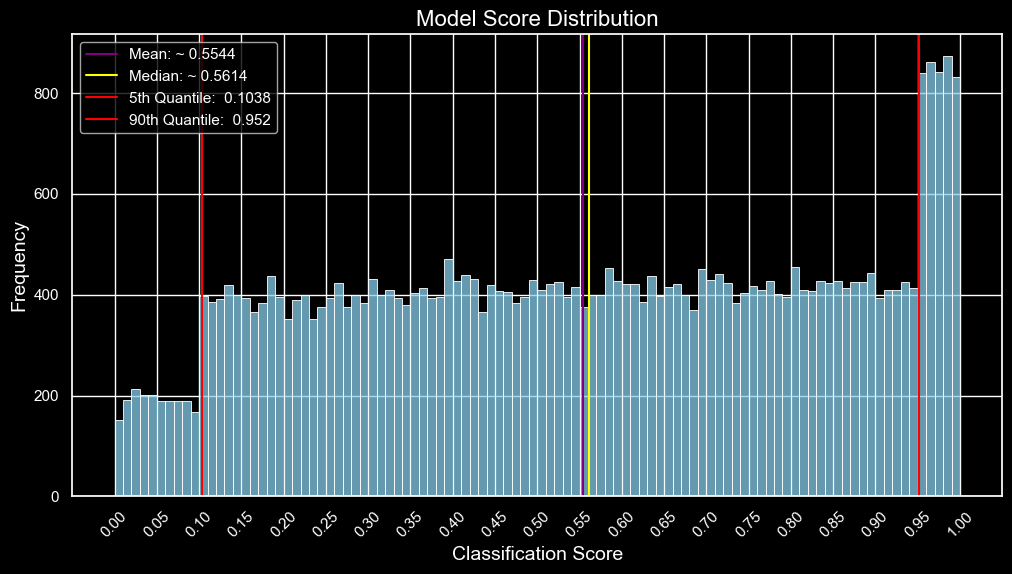

In [315]:
# Setting dark theme
sns.set(style="darkgrid")
plt.style.use("dark_background")

# Creating histogram 
plt.figure(figsize=(12, 6))
sns.histplot(data['classification_score'], bins=100, color="skyblue",stat='count')
plt.title('Model Score Distribution', fontsize=16)
plt.xlabel('Classification Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Defines x-axis ticks at 0.05 intervals up to the max classification score, rotating labels 45 degrees for clarity.
plt.xticks(np.arange(0, data['classification_score'].max() + 0.05, step=0.05), rotation=45)

# Calculates and rounds the mean, median, 5th, and 90th percentile values of the classification scores.
mean_score = round(data['classification_score'].mean(), 4)
median_score = round(data['classification_score'].median(), 4)
quantile_5 = round(data['classification_score'].quantile(0.05), 4)
quantile_90 = round(data['classification_score'].quantile(0.90), 4)

# Highlighting mean, median, and quantiles with vertical lines
plt.axvline(x=mean_score, color='purple', linestyle='-', label=f"Mean: ~ {mean_score}")
plt.axvline(x=median_score, color='yellow', linestyle='-', label=f"Median: ~ {median_score}")
plt.axvline(x=quantile_5, color='red', linestyle='-', label=f"5th Quantile:  {quantile_5}")
plt.axvline(x=quantile_90, color='red', linestyle='-', label=f"90th Quantile:  {quantile_90}")

plt.legend()
plt.show()



## Model Scores Distribution Analysis

- **Score Range Uniformity:** <br><br>
Uniform distributions are shown across low (0 - 0.1), medium (0.1 - 0.95), and high (0.95 - 1) risk score ranges, indicating consistent model scoring per category.  
<br>

- **Sensitivity of Threshold:**   The model's sensitivity to threshold adjustments differs across score ranges:<br><br>
In the high range (0.95 - 1), densely packed scores mean a small threshold adjustment significantly alters many transactions' classifications, showcasing high sensitivity.
For medium and low ranges, scores are more spread out; thus, a similar threshold tweak affects fewer transactions, indicating lower sensitivity to the output of the model (Approved or Decline).
 




### Fee Percentage Calculation: Balancing fee revenue with chargeback costs


1. **Objective:** Establish fee revenues at double the chargeback costs for balance:

   Define the relationship between total chargeback amount and total fee revenue:

   $$
   \frac{\text{Total Chargeback Amount}}{\text{Total Fee Revenue}} = \frac{1}{2}.
   $$<br>

  
2. **Revenue Equality:** Derive the total fee revenue needed to match this objective:


   $$
   \text{Total Fee Revenue} = 2 \times \text{Total Chargeback Amount}.
   $$<br>


3. **Fee Calculation:** Expand the fee percentage calculation into detailed steps:

   First, express the fee revenue in terms of the fee percentage and approved amount:

   $$
   \text{Total Fee Revenue} = \text{Fee Percentage} \times \text{Total Approved Amount}.
   $$<br>

   Then, insert the proportional relationship into the fee revenue formula:

   $$
   2 \times \text{Total Chargeback Amount} = \text{Fee Percentage} \times \text{Total Approved Amount}.
   $$<br>

   Isolate the fee percentage for clarity:

   $$
   \text{Fee Percentage} = \left( \frac{2 \times \text{Total Chargeback Amount}}{\text{Total Approved Amount}} \right) \times 100\%.
   $$<br>


### Implementation in Code:

In [316]:
# Calculate the total amount from approved transactions
total_approved_amount = data[data['order_status'] == 'approved']['price'].sum()

# Calculate the total amount from chargebacks
total_chargeback_amount = data[data['order_status'] == 'chargeback']['price'].sum()


fee_percentage = (2 * total_chargeback_amount) / total_approved_amount * 100  # Convert to percentage


print(f"The fee percetage needed is: {round(fee_percentage,2)} %")

The fee percetage needed is: 27.33 %


### Calculated Fee Percentage: The necessary fee is **27.33%**.

Applying a fee of 27.33% (rounded to two decimals for precision) on approved transactions achieves our objective: the fee revenue becomes twice the total chargeback costs. This approach ensures chargeback expenses are kept at 50% of our fee revenue..

# Dynamic Fee Calculation Function

we will create a Python function that dynamically calculates the required fee percentage as outlined in Task 3 but on a randomized sample of 10,000 orders from the dataset. This function will help simulate the fee percentage calculation across different subsets of data, providing insights into how the fee might vary with different transaction samples and ensuring robustness in our fee strategy.

In [317]:
def calculate_fee_percentage(data, sample_size=10000):
    """
    This function selects a random sample of orders, calculates the total amount 
    for approved transactions and chargebacks, then computes the required fee 
    percentage to align chargeback costs with 50% of the fee revenue.
    
    :param data: DataFrame containing order data
    :param sample_size: Number of orders to sample, default is 10,000
    :return: The calculated fee percentage
    """
    # Ensure the data has at least sample_size orders
    if len(data) < sample_size:
        raise ValueError("The dataset contains fewer orders than the requested sample size.")
    
    # Randomly select sample_size orders
    sample_data = data.sample(n=sample_size)
    
    # Calculate the total amount from approved transactions
    total_approved_amount = sample_data[sample_data['order_status'] == 'approved']['price'].sum()

    # Calculate the total amount from chargebacks
    total_chargeback_amount = sample_data[sample_data['order_status'] == 'chargeback']['price'].sum()

    # Compute the fee percentage
    fee_percentage = (2 * total_chargeback_amount) / total_approved_amount * 100  # Convert to percentage

    return fee_percentage

### Visualization: Chargeback Proportions by Order Source


we will create a bar chart to visualize and compare the proportion of chargebacks across different order sources. This analysis will help us identify if certain order sources are more susceptible to chargebacks, which can inform targeted risk management strategies.

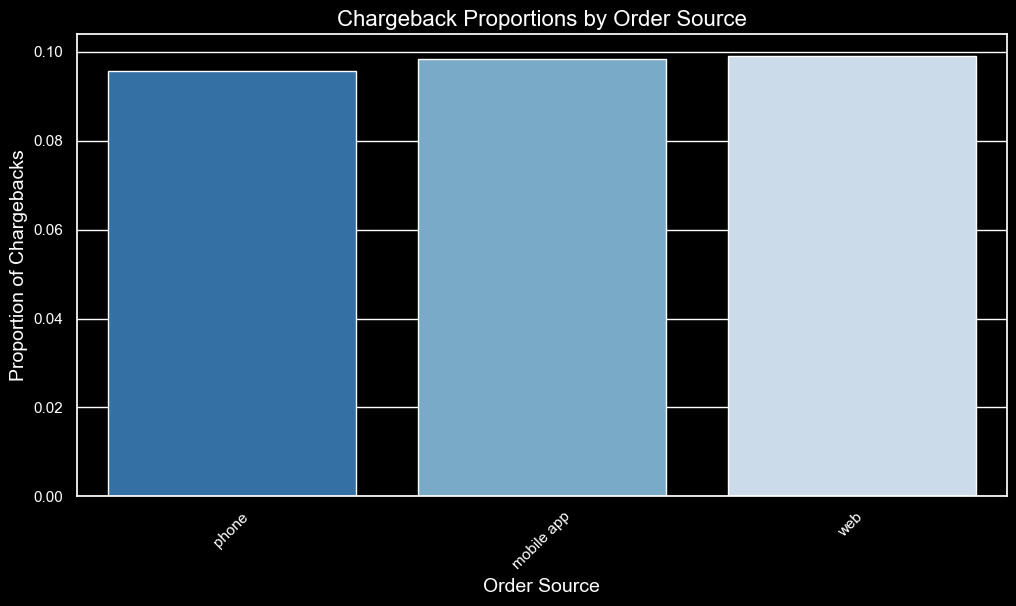

In [318]:
# Calculating the proportion of chargebacks per order source
order_source_stats = data.groupby('order_source')['order_status'].value_counts(normalize=True).unstack()
chargeback_proportions = order_source_stats['chargeback'].sort_values()

# Creating the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=chargeback_proportions.index, y=chargeback_proportions.values, palette="Blues_r")
plt.title('Chargeback Proportions by Order Source', fontsize=16)
plt.xlabel('Order Source', fontsize=14)
plt.ylabel('Proportion of Chargebacks', fontsize=14)
plt.xticks(rotation=45)
plt.show()


### Chargeback Proportions by Order Source Analysis

- **Phone:** 9.57%
- **Mobile App:** 9.84%
- **Web:** 9.90%

The data shows that web orders have slightly more chargebacks than phone and mobile app orders. But the differences are small, meaning no source stands out as significantly more prone to chargebacks. This suggests it's important to spread risk management efforts evenly across all sources, with a bit more attention on web transactions due to their slightly higher chargeback rates.

### Analysis of AVS Mismatch and Risk Level

To assess the risk level associated with AVS (Address Verification System) mismatches in the dataset, we'll conduct a comparative analysis between orders with and without AVS mismatches as we did in task 5. This analysis will provide insights into whether AVS mismatches are associated with higher or lower risk levels.

- **Grouping by AVS Mismatch:** We'll divide the dataset into two segments: orders with AVS mismatches and those without.
- **Calculating Chargeback Rates:** Within each segment, we'll determine the proportion of orders that resulted in chargebacks.
- **Comparative Analysis:** We'll compare the chargeback rates between the two segments to assess the risk level associated with AVS mismatches.

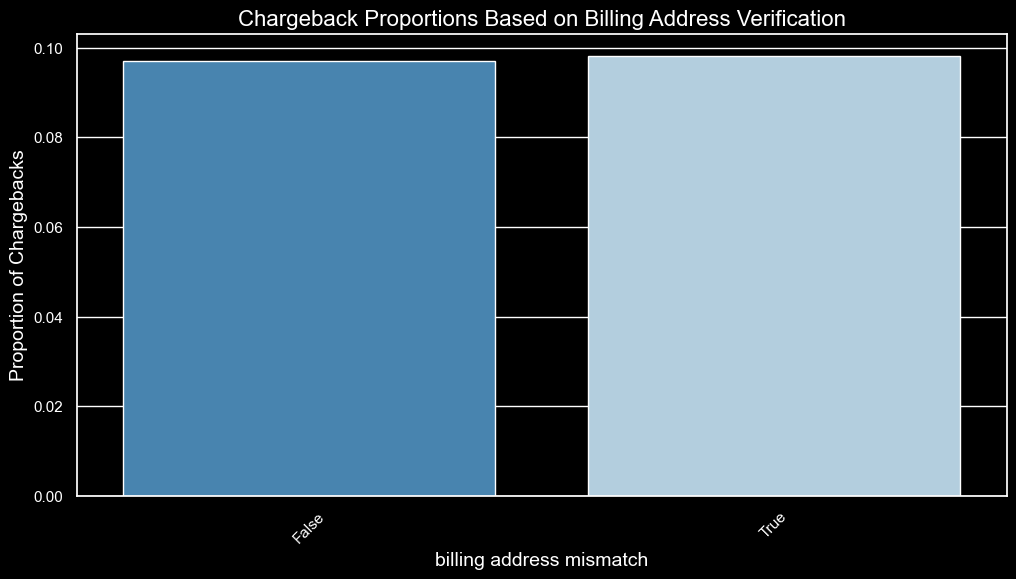

In [319]:
# Calculating the proportion of chargebacks per order source
mismatch_stats = data.groupby('avs_mismatch')['order_status'].value_counts(normalize=True).unstack()
chargeback_proportions = mismatch_stats['chargeback']

# Creating the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=chargeback_proportions.index, y=chargeback_proportions.values, palette="Blues_r")
plt.title('Chargeback Proportions Based on Billing Address Verification', fontsize=16)
plt.xlabel('billing address mismatch', fontsize=14)
plt.ylabel('Proportion of Chargebacks', fontsize=14)
plt.xticks(rotation=45)
plt.show()

### Chargeback Proportions by AVS Mismatch Analysis

- **False:** 9.71%
- **True:** 9.82%

These results suggest that the proportion of chargebacks is slightly higher for orders with AVS mismatches compared to those without. However, the differences are minimal Like we observed in Task 5 when examining order sources, indicating that AVS mismatches may have a modest impact on chargeback rates.



### Statistical Test for AVS Mismatch Impact

In addition to visual analysis, it is crucial to **statistically test** whether the observed difference in chargeback proportions for AVS mismatched and non-mismatched orders is significant. We will apply the chi-squared test to determine if the differences we see in the proportions are likely to be due to chance or represent a significant relationship between AVS mismatch and chargeback likelihood.

- **Chi-Squared Test Preparation:** Create a contingency table to show the relationship between AVS mismatch (True/False) and order status (chargeback/approved), essential for the chi-squared analysis.

- **Statistical Analysis:** Compute the chi-squared statistic and p-value to evaluate the independence of AVS mismatch and order status.

In [320]:
data_summary =  data.groupby('avs_mismatch')['order_status'].value_counts().unstack()

chi2, p, dof, expected = chi2_contingency(data_summary)

data_summary

order_status,approved,chargeback
avs_mismatch,,
False,16716,1797
True,20121,2191


In [321]:
# Calculating the Chi-squared test statistic, p-value, degrees of freedom, and expected frequencies
chi2, p, dof, expected = chi2_contingency(data_summary)

# Displaying the results
print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")

Chi-squared Statistic: 0.13437077741868167
P-value: 0.7139426257869617


📊 **Chi-Squared Test Results Summary:**

- **Chi-Squared Statistic:** \(0.134\) - Low, indicating minimal deviation between observed and expected frequencies.
- **P-value:** \(0.714\) - Not statistically significant, suggesting no strong evidence of an association between AVS mismatch and chargeback rates.

**Conclusion:** AVS mismatch status does not significantly impact the likelihood of chargebacks in our dataset. It should not be a standalone risk indicator in the company's models. 🚀

## Three Interesting Breakdowns/Insights from the Data


### 1. Analyzing Monthly Chargeback Rates for the company

Understanding chargeback rates is crucial for risk management at the company. By identifying trends in chargeback rates, the company can implement proactive measures to minimize risks and optimize operations.

We're using a moving average to smooth out fluctuations and highlight long-term trends. This aids in discerning long-term patterns in chargeback rates, enabling more informed decision-making for crafting effective risk management strategies.

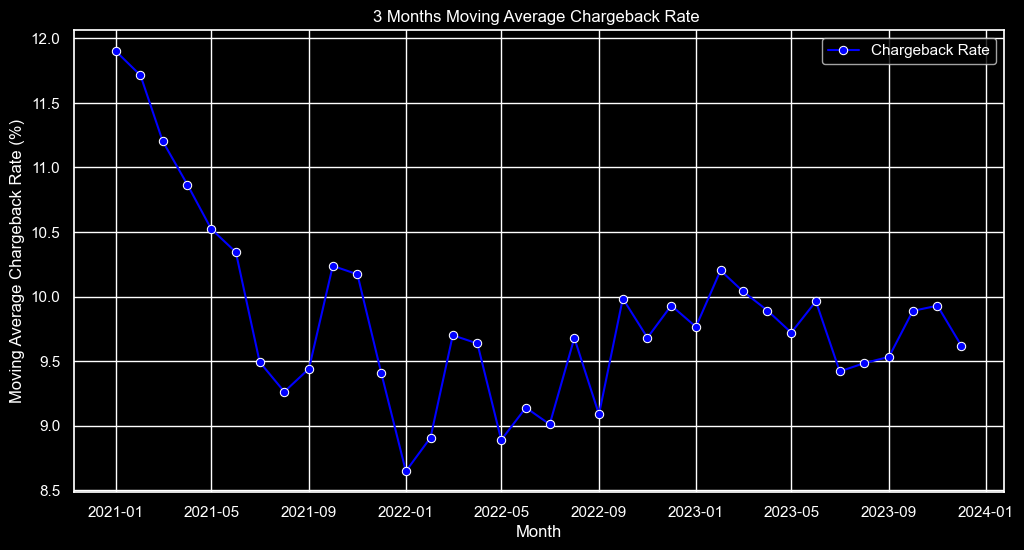

In [322]:
# Converting 'order_date' to datetime format
data['order_date'] = pd.to_datetime(data['order_date'])

# Directly extracting year and month 
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month

# Creating a boolean column so we can count chargebacks 
data['chargeback_count'] = data['order_status'].apply(lambda x: 1 if x == 'chargeback' else 0)

# Aggregating total orders and chargeback counts by year and month
monthly_data = data.groupby(['year', 'month']).agg(
    total_orders=pd.NamedAgg(column='order_id', aggfunc='count'),
    total_chargebacks=pd.NamedAgg(column='chargeback_count', aggfunc='sum')
).reset_index()

# Calculating chargeback rate
monthly_data['chargeback_rate'] = (monthly_data['total_chargebacks'] / monthly_data['total_orders']) * 100

# Creating a datetime column for plotting
monthly_data['date'] = pd.to_datetime(monthly_data.assign(day=1)[['year', 'month','day']])

# Calculating the moving average for the chargeback rate using a 3-month window
monthly_data['chargeback_rate_ma'] = monthly_data['chargeback_rate'].rolling(window=3, min_periods=1).mean()

# Plotting
plt.figure(figsize=(12, 6))

# Chargeback rate moving average plot
sns.lineplot(x='date', y='chargeback_rate_ma', data=monthly_data, label='Chargeback Rate', marker='o', color='blue')
plt.ylabel('Moving Average Chargeback Rate (%)')
plt.xlabel('Month')
plt.title('3 Months Moving Average Chargeback Rate ')
plt.legend()

plt.show()


### 🚀 **Streamlined Insights from Chargeback Rate Trends:**

#### **Key Observations:**
- **2021 Decrease:** Indicates the company's anti-fraud tools or AI might be improving.
- **2022 Increase:** Suggests potential challenges. This rise could mean fraudsters are adapting, or there may be external factors at play. But it's also possible this uptick is a correction, returning to average levels after an unusually low period at the start of 2022.

#### **Understanding the Trends:**
- **Event Correlations:** Matching the company changes or significant market shifts with these trends can help clarify their origins.
- **Industry Context:** Seeing how the company compares with broader industry trends can indicate if these changes are isolated or widespread.

#### **Looking Ahead:**
- **Further Exploration Needed:** The recent increase deserves attention to determine its nature. It could be a sign of emerging challenges or simply a return to normalcy after an atypical low in early 2022, suggesting the start of that year was an anomaly.


## 2.  Weekly Transaction Metrics Analysis

We're zooming into how this company's key metrics : **total orders**, **total chargebacks**, **chargeback rates**, and **Merchant Revenue** 
fluctuate across different weekdays. By dissecting this data, we aim to spotlight any notable patterns or shifts that can sharpen our fraud detection and operational strategies.

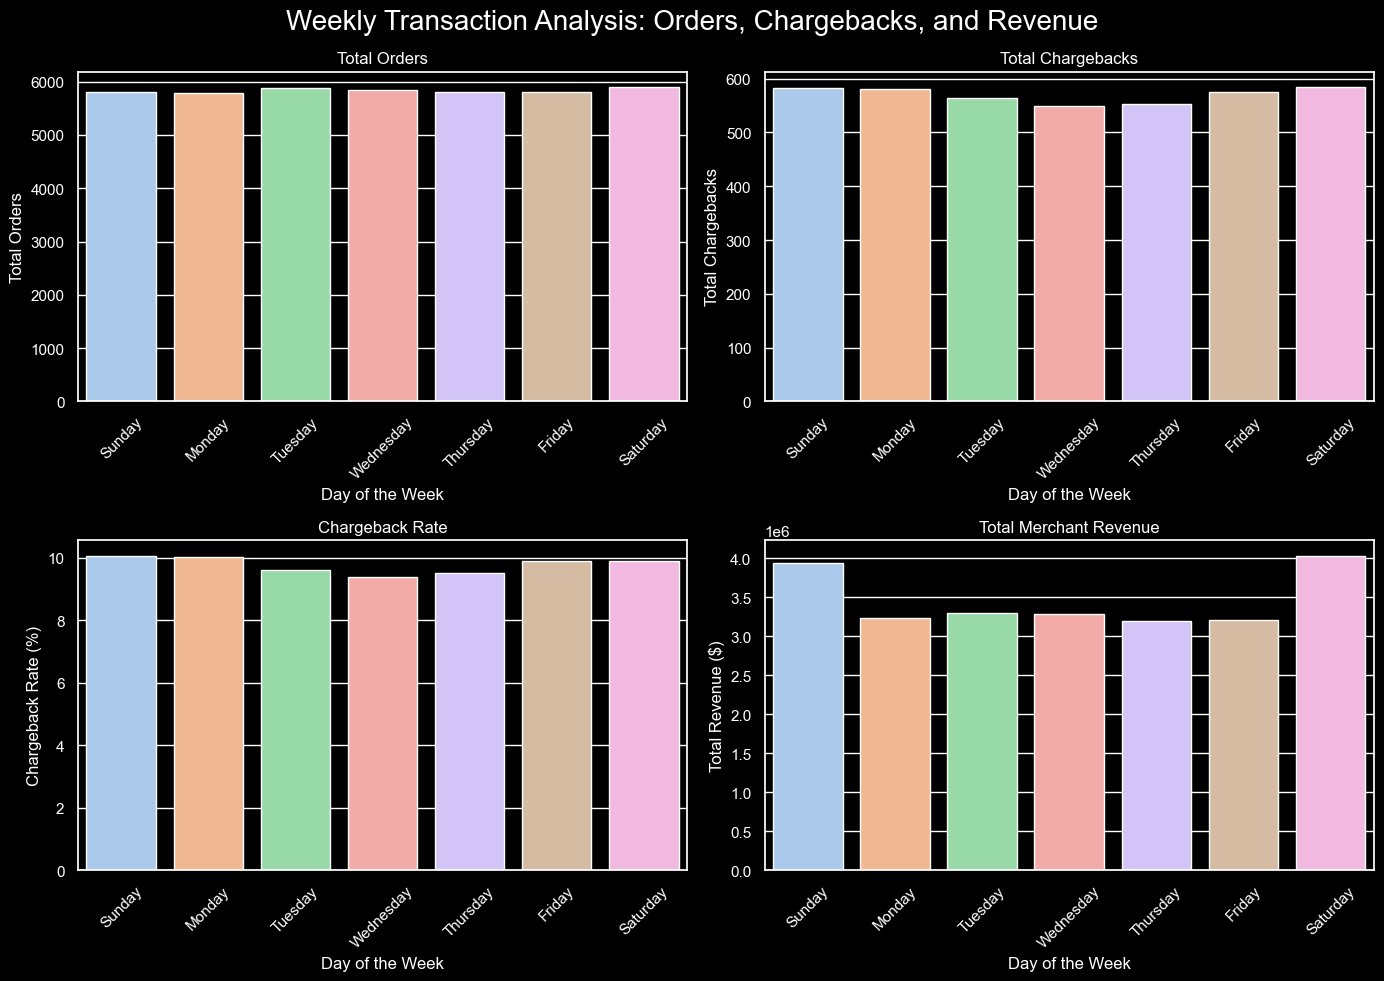

In [323]:
# Creating Day_of_week column for Anlysis
data['day_of_week'] = data['order_date'].dt.day_name()

# Aggregating data by day of the week
weekly_data = data.groupby('day_of_week').agg(
    total_orders=pd.NamedAgg(column='order_id', aggfunc='count'),
    total_chargebacks=pd.NamedAgg(column='chargeback_count', aggfunc='sum'),
    total_revenue=pd.NamedAgg(column='price', aggfunc='sum')
)

# Calculating chargeback rate
weekly_data['chargeback_rate'] = (weekly_data['total_chargebacks'] / weekly_data['total_orders']) * 100

# Sorting the days of the week
ordered_days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekly_data = weekly_data.reindex(ordered_days)

# Setting dark theme for plots
sns.set(style="darkgrid")
plt.style.use("dark_background")

# Define color palette
palette = sns.color_palette("pastel", n_colors=7)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Add title to figure
fig.suptitle('Weekly Transaction Analysis: Orders, Chargebacks, and Revenue',size = 20)

# Plot for total orders
sns.barplot(ax=axs[0, 0], x=weekly_data.index, y=weekly_data['total_orders'], palette=palette)
axs[0, 0].set_title('Total Orders')
axs[0, 0].set_xlabel('Day of the Week')
axs[0, 0].set_ylabel('Total Orders')

# Plot for total chargebacks
sns.barplot(ax=axs[0, 1], x=weekly_data.index, y=weekly_data['total_chargebacks'], palette=palette)
axs[0, 1].set_title('Total Chargebacks')
axs[0, 1].set_xlabel('Day of the Week')
axs[0, 1].set_ylabel('Total Chargebacks')

# Plot for chargeback rate
sns.barplot(ax=axs[1, 0], x=weekly_data.index, y=weekly_data['chargeback_rate'], palette=palette)
axs[1, 0].set_title('Chargeback Rate')
axs[1, 0].set_xlabel('Day of the Week')
axs[1, 0].set_ylabel('Chargeback Rate (%)')

# Plot for total revenue
sns.barplot(ax=axs[1, 1], x=weekly_data.index, y=weekly_data['total_revenue'], palette=palette)
axs[1, 1].set_title('Total Merchant Revenue')
axs[1, 1].set_xlabel('Day of the Week')
axs[1, 1].set_ylabel('Total Revenue ($)')

# Rotating x-tick labels for all subplots for better readability
for ax in axs.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

# Adjusting layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

###   🚀 **Weekly Transaction Patterns: Stability and Subtle Shifts**

- **Total Orders:** Steady across all days, indicating a consistent transaction volume from Sunday to Saturday.
- **Total Chargebacks & Chargeback Rate:**  The trend shows a gentle decrease early in the week, bottoming out on Wednesday, with a modest increase towards the weekend. This slight fluctuation suggests relatively stable risk levels, with no drastic changes to suggest significant vulnerabilities on specific days.
- **Total Revenue:** Peaks on Sunday and Saturday suggest higher end-of-week spending, possibly reflecting weekend shopping behavior.

### 🔍 **Strategic Actions for this comapny Based on Weekly Trends:**

- **Optimize Fraud Detection:** Leverage the stability in daily chargebacks to fine-tune fraud detection algorithms, ensuring they are calibrated for subtle midweek dips and weekend upticks.
- **Tailored Marketing Strategies:** Align promotions and customer engagement to capitalize on the observed revenue peaks on Sunday and Saturday.


## 3.  **Analyzing Customer Account Age and Chargeback Rates:**

Now, let's delve into the relationship between customer account age and chargeback rates. We'll create categorical age brackets based on the duration of account age and examine how chargeback rates vary across these brackets. Additionally, we'll explore chargeback rates within the first month of account creation to gain insights into early customer behavior.

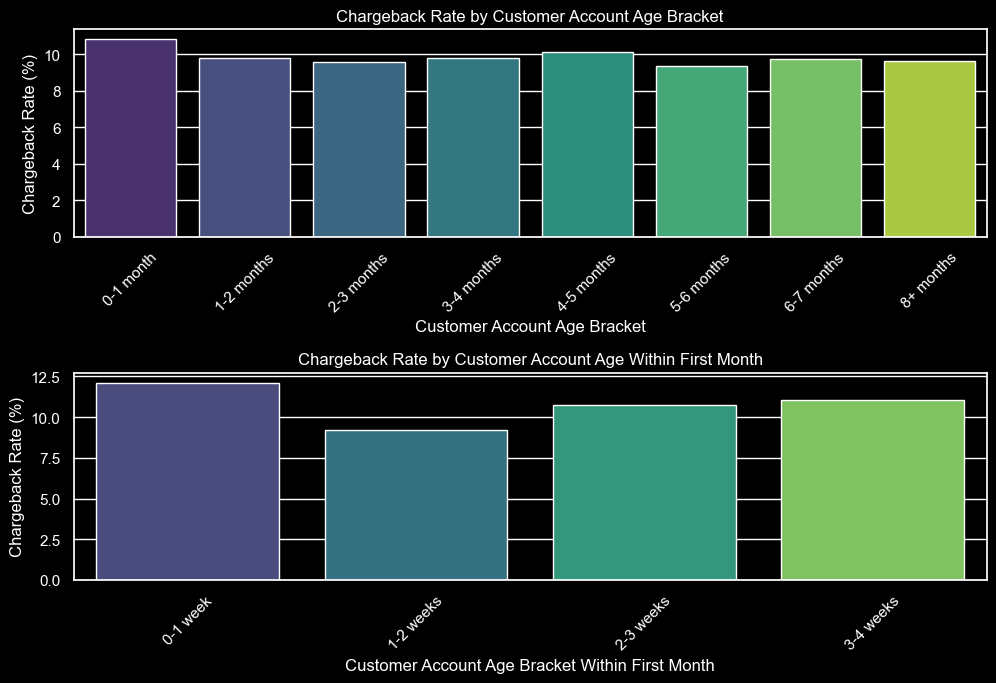

In [324]:
# Create a new categorical column 'age_bracket' based on the 'customer_account_age' column
# The 'customer_account_age' column values are binned into different age brackets using pd.cut() function

data['age_bracket'] = pd.cut(data['customer_account_age'], 
                             bins=[-1, 30, 60, 90,120, 150, 180, 210, float('inf')], 
                             labels=['0-1 month', '1-2 months', '2-3 months','3-4 months','4-5 months', '5-6 months','6-7 months', '8+ months'])

# Calculate chargeback rates by age bracket
# First, we'll get the total count of orders and chargebacks in each bracket.
age_analysis = data.groupby('age_bracket')['order_status'].value_counts().unstack()
age_analysis['chargeback_rate'] = age_analysis['chargeback'] / (age_analysis['approved'] + age_analysis['chargeback']) * 100

# Define weekly bins within the first month
data['first_month_age_bracket'] = pd.cut(
    data['customer_account_age'],
    bins=[-1, 7, 14, 21, 30],  # Week-based bins
    labels=['0-1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks']
)
# Filtering data for the first month
first_month_data = data[data['customer_account_age'] <= 30]

# Grouping by the new age brackets to calculate chargeback rates
first_month_analysis = first_month_data.groupby('first_month_age_bracket')['order_status'].value_counts().unstack()
first_month_analysis['chargeback_rate'] = first_month_analysis['chargeback'] / (first_month_analysis['approved'] + first_month_analysis['chargeback']) * 100

# Setting up the plot area
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Plot for overall account age brackets
sns.barplot(ax=axs[0], x=age_analysis.index, y=age_analysis['chargeback_rate'], palette='viridis')
axs[0].set_title('Chargeback Rate by Customer Account Age Bracket')
axs[0].set_xlabel('Customer Account Age Bracket')
axs[0].set_ylabel('Chargeback Rate (%)')
axs[0].tick_params(axis='x', rotation=45)

# Plot for first month breakdown
sns.barplot(ax=axs[1], x=first_month_analysis.index, y=first_month_analysis['chargeback_rate'], palette='viridis')
axs[1].set_title('Chargeback Rate by Customer Account Age Within First Month')
axs[1].set_xlabel('Customer Account Age Bracket Within First Month')
axs[1].set_ylabel('Chargeback Rate (%)')
axs[1].tick_params(axis='x', rotation=45)

# Adjusting layout to prevent overlap and ensure clarity
plt.tight_layout()

# Show the plot
plt.show()

📊 **Insights from Chargeback Rate Analysis:**

⚠️ **First Month Impact:** The initial month exhibits the highest chargeback rate, peaking at approximately 11%. Subsequent months maintain a stable rate around 10%.

📆 **Weekly Breakdown:** Within the first month, the first week shows the highest chargeback rate at around 12%, while the following weeks stabilize at 9-10%.

⚡ **Actionable Insight:** Early account activity, especially within the first week, poses heightened risk. Implementing targeted risk mitigation strategies is crucial to bolster transaction security.

🎉 **Assignment Completion:**

By carefully examining multiple data features, we've uncovered crucial insights for this the company risk management. These findings empower us to make informed decisions and strengthen this company's ability to mitigate risk effectively.